<p style="text-align:center; ">
<img src="https://th.bing.com/th/id/R.0faa64ba24b82dc7f36f270fea63e93b?rik=il1DKxTqD2BJ3A&pid=ImgRaw&r=0", style='width: 1000px; height: 600px;'>
</p>

Pollution is a major threat to our environment and health, caused by human activities such as industrial production, vehicle emissions, and improper waste disposal. Air pollution leads to respiratory diseases and contributes to climate change, while water pollution harms marine life and contaminates drinking water. Plastic waste clogs oceans and endangers wildlife, making it crucial to adopt eco-friendly habits like recycling and reducing plastic use. Noise and soil pollution also have harmful effects, impacting both humans and ecosystems. To protect our planet, we must take action by promoting sustainable practices and enforcing stricter environmental regulations.

1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import normal_ad
import seaborn as sns
import matplotlib.pyplot as plt


2. Load the Dataset

In [2]:
df = pd.read_csv('/content/pollution_us_2000_2016.csv')

3. Data Preprocessing

In [3]:
# Step 3: Convert 'Date Local' to datetime format and sort the data
df['Date Local'] = pd.to_datetime(df['Date Local'])
df = df.sort_values('Date Local')

# Filter data from 2001 onwards
df = df[df['Date Local'] >= '2001-01-01']

4. Select Relevant Columns

In [4]:
# Step 4: Select relevant columns for analysis
df = df[['Date Local', 'NO2 Mean', 'O3 Mean', 'SO2 Mean', 'CO Mean', 'NO2 1st Max Value']]
# diplay head
df.head()

,Date Local,NO2 Mean,O3 Mean,SO2 Mean,CO Mean,NO2 1st Max Value
111580,2001-01-01,21.521739,0.012708,0.00,1.326087,35.0
111581,2001-01-01,21.521739,0.012708,0.00,1.100000,35.0
114482,2001-01-01,27.727273,0.004542,3.85,2.277273,43.0
111582,2001-01-01,21.521739,0.012708,0.00,1.326087,35.0
111583,2001-01-01,21.521739,0.012708,0.00,1.100000,35.0


5. Handle Missing Values

In [5]:
# Step 5: Fill missing values using forward fill (ffill)
df['NO2 Mean'] = df['NO2 Mean'].ffill()
df['O3 Mean'] = df['O3 Mean'].ffill()
df['SO2 Mean'] = df['SO2 Mean'].ffill()
df['CO Mean'] = df['CO Mean'].ffill()
df['NO2 1st Max Value'] = df['NO2 1st Max Value'].ffill()

6. Extract Time Features

In [6]:
# Step 6: Extract time-based features (Month, Weekday)
df['Month'] = df['Date Local'].dt.month
df['Weekday'] = df['Date Local'].dt.weekday

# Define fixed public holidays
holidays_base = ['01-01', '07-04', '12-25', '11-11', '05-01', '09-01']
years_in_data = df['Date Local'].dt.year.unique()

# Generate holiday dates for each year in the dataset
all_holidays = []
for year in years_in_data:
    for holiday in holidays_base:
        holiday_date = f'{year}-{holiday}'
        all_holidays.append(pd.to_datetime(holiday_date))

# Add a column to indicate whether a date is a holiday
df['Is_Holiday'] = df['Date Local'].isin(all_holidays).astype(int)

7. Set Index and Handle Duplicates

In [7]:
# Step 7: Set 'Date Local' as index for ARIMA
df.set_index('Date Local', inplace=True)

# Check for duplicate indices and average them if found
if df.index.duplicated().any():
    df = df.groupby(df.index).mean()

# Set frequency to weekly
df = df.asfreq('W', method='ffill')

# Print the frequency of the index
print(f"Index frequency: {df.index.freq}")

Index frequency: <Week: weekday=6>


8. Visualize ACF and PACF

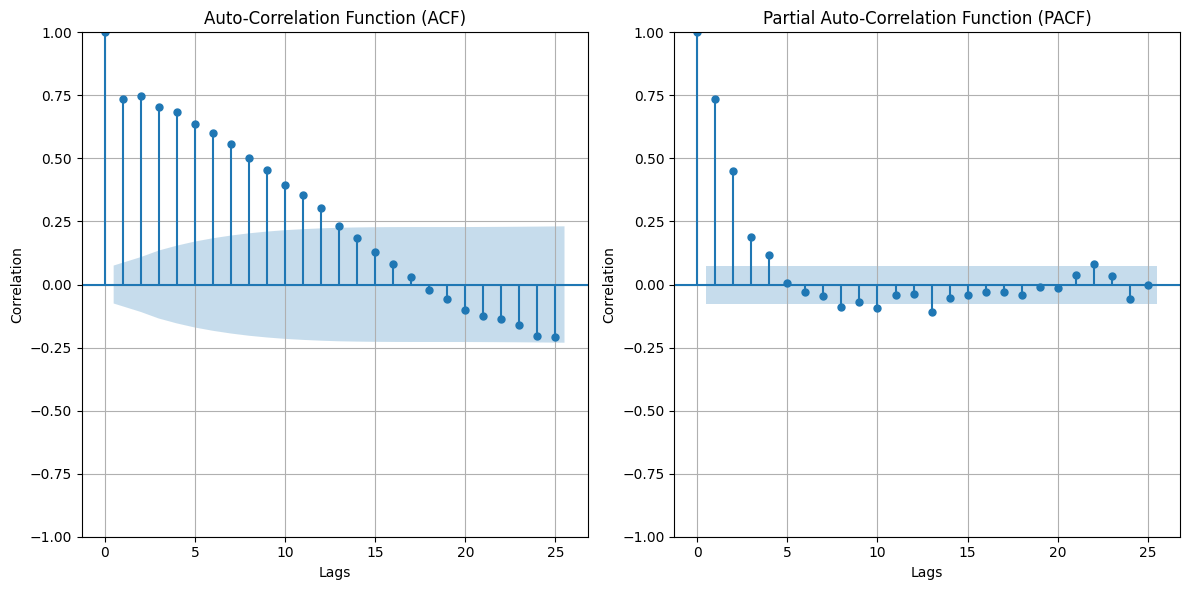

In [8]:
# Step 8: Plot Auto-Correlation Function (ACF) and Partial Auto-Correlation Function (PACF)
plt.figure(figsize=(12, 6))

# ACF plot
plt.subplot(1, 2, 1)
plot_acf(df['NO2 Mean'], lags=25, ax=plt.gca())
plt.title('Auto-Correlation Function (ACF)')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.grid(True)

# PACF plot
plt.subplot(1, 2, 2)
plot_pacf(df['NO2 Mean'], lags=25, ax=plt.gca())
plt.title('Partial Auto-Correlation Function (PACF)')
plt.xlabel('Lags')
plt.ylabel('Correlation')
plt.grid(True)

plt.tight_layout()
plt.show()

9. Split Data into Training and Testing Sets

In [9]:
test_size = int(len(df) * 0.2) # Use 20% of the data for testing

# Split the data into training and testing sets
train = df[:-test_size]
test = df[-test_size:]

10.Display Correlations

                   NO2 Mean   O3 Mean  SO2 Mean   CO Mean  NO2 1st Max Value  \
NO2 Mean           1.000000 -0.684510  0.634650  0.944252           0.952150   
O3 Mean           -0.684510  1.000000 -0.194464 -0.665671          -0.527064   
SO2 Mean           0.634650 -0.194464  1.000000  0.605347           0.639575   
CO Mean            0.944252 -0.665671  0.605347  1.000000           0.860670   
NO2 1st Max Value  0.952150 -0.527064  0.639575  0.860670           1.000000   
Year              -0.509896  0.077620 -0.778958 -0.521249          -0.564593   
Month              0.020490 -0.245237 -0.060682  0.005372          -0.036184   

                       Year     Month  
NO2 Mean          -0.509896  0.020490  
O3 Mean            0.077620 -0.245237  
SO2 Mean          -0.778958 -0.060682  
CO Mean           -0.521249  0.005372  
NO2 1st Max Value -0.564593 -0.036184  
Year               1.000000 -0.005045  
Month             -0.005045  1.000000  


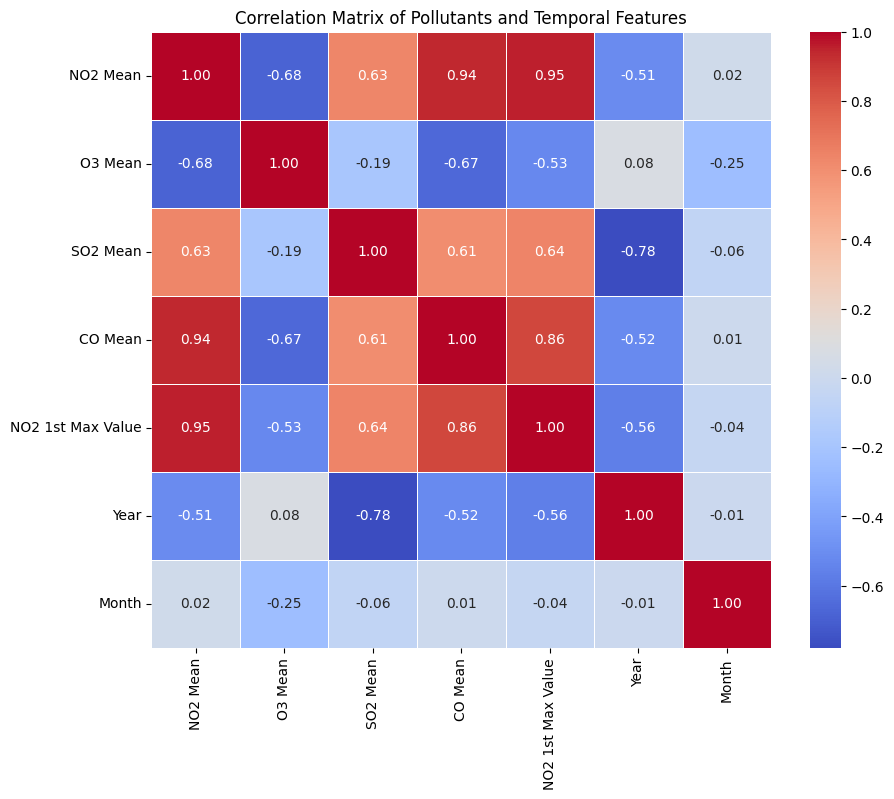

In [10]:
# Access 'Date Local' from the index
df['Year'] = df.index.year
df['Month'] = df.index.month

# Compute correlation matrix with all relevant variables
correlation_matrix = df[['NO2 Mean', 'O3 Mean', 'SO2 Mean', 'CO Mean', 'NO2 1st Max Value', 'Year', 'Month']].corr()

# Display correlation values
print(correlation_matrix)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Pollutants and Temporal Features")
plt.show()

11. Define Exogenous Variables

In [11]:
# Step 10: Define exogenous variables (other influencing factors)
exog_train = train[['O3 Mean', 'SO2 Mean', 'CO Mean', 'NO2 1st Max Value', 'Month', 'Weekday', 'Is_Holiday']]
exog_test = test[['O3 Mean', 'SO2 Mean', 'CO Mean', 'NO2 1st Max Value', 'Month', 'Weekday', 'Is_Holiday']]

12. Train the ARIMA Model

In [12]:
# Step 11: Train the ARIMA model
model = ARIMA(train['NO2 Mean'], exog=exog_train, order=(5, 1, 0))
model_fit = model.fit()

# Forecast values
# Use the length of the test set for the number of steps to forecast
forecast = model_fit.forecast(steps=len(test), exog=exog_test)

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


13. Evaluate Model Performance

In [13]:
# Step 12: Compute residuals
y_true = test['NO2 Mean'].values
residuals = y_true - forecast

# Calculate performance metrics
mae = mean_absolute_error(y_true, forecast)
rmse = np.sqrt(mean_squared_error(y_true, forecast))

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 0.44905923841706263
Root Mean Squared Error (RMSE): 0.6129275257882887


14. Visualize Predictions vs. Actual Values

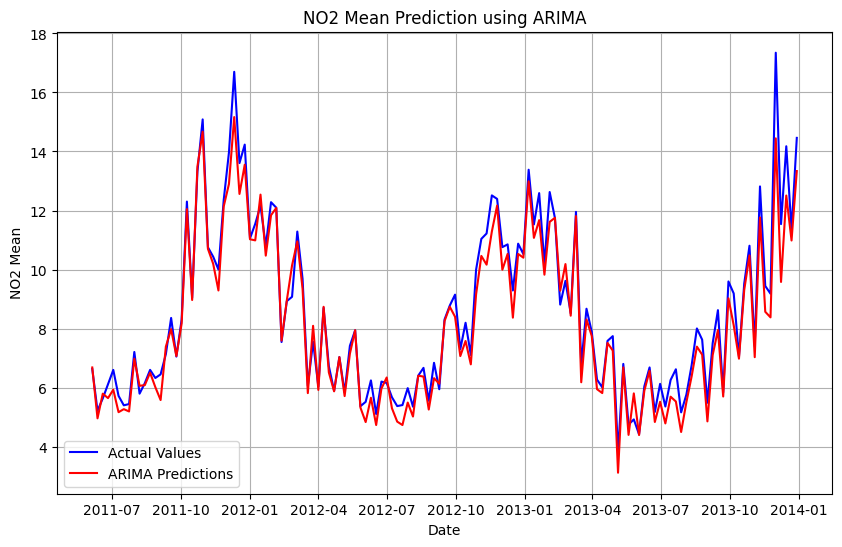

In [14]:
# Step 13: Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(test.index, y_true, label='Actual Values', color='blue')
plt.plot(test.index, forecast, label='ARIMA Predictions', color='red')
plt.title('NO2 Mean Prediction using ARIMA')
plt.xlabel('Date')
plt.ylabel('NO2 Mean')
plt.legend()
plt.grid(True)
plt.show()

15. Analyze Residuals

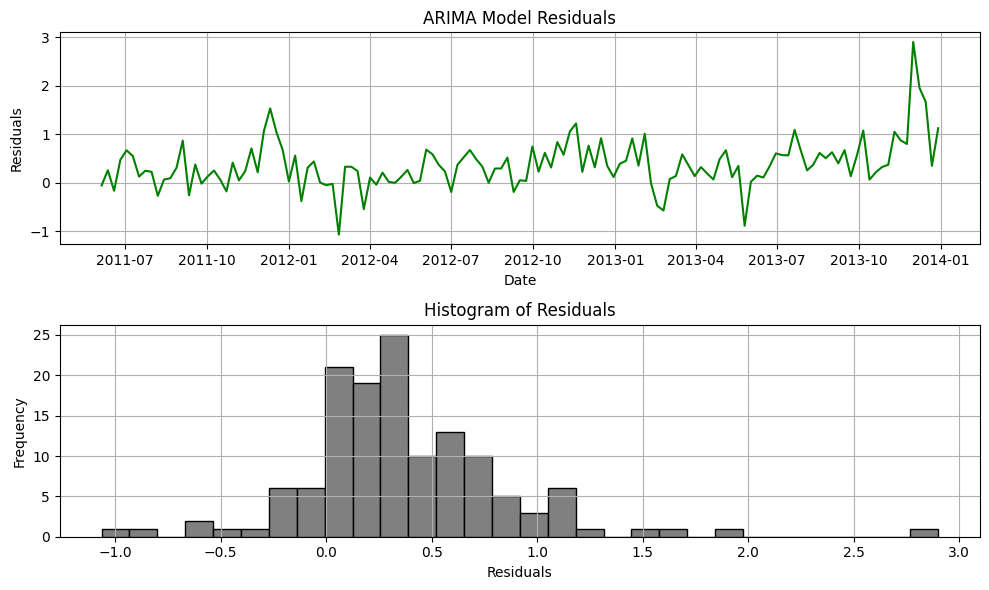

In [15]:
# Step 14: Plot residuals
plt.figure(figsize=(10, 6))

# Residuals plot
plt.subplot(2, 1, 1)
plt.plot(test.index, residuals, label='Residuals', color='green')
plt.title('ARIMA Model Residuals')
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.grid(True)

# Residuals histogram
plt.subplot(2, 1, 2)
plt.hist(residuals, bins=30, color='gray', edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

16. Compare Residuals on Holidays vs. Non-Holidays

In [16]:
# Step 15: Create a DataFrame for residuals
residuals_df = pd.DataFrame(residuals, index=test.index)
residuals_df['Is_Holiday'] = residuals_df.index.isin(all_holidays)

17. Visualize Residuals Distribution on Holidays vs. Other Days

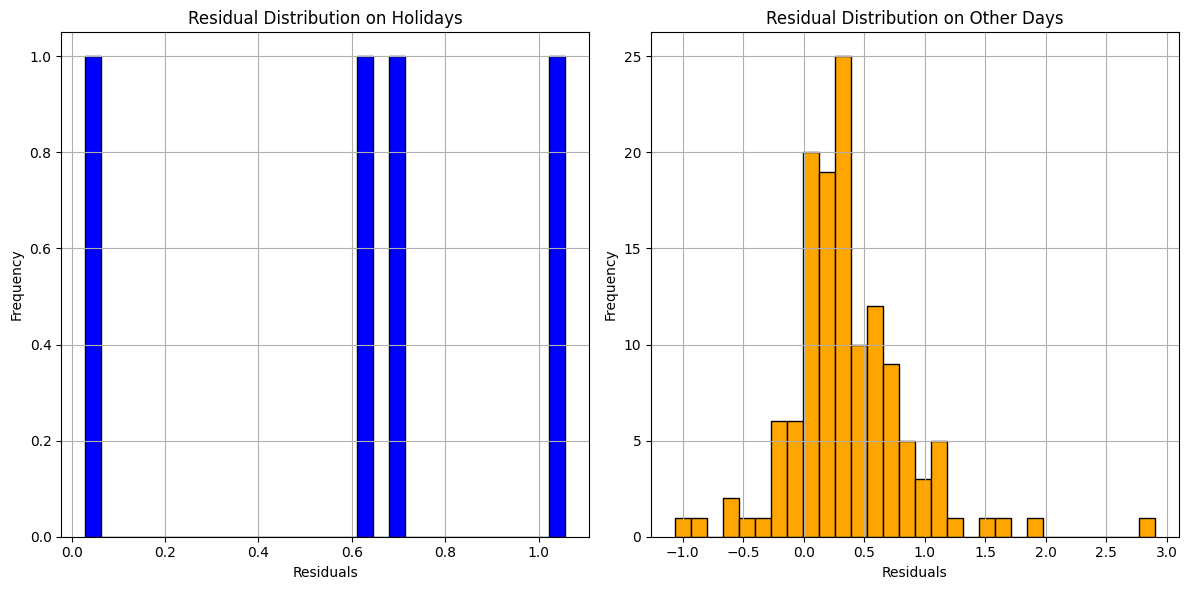

In [17]:
# Step 16: Compare residual distributions on holidays and other days
plt.figure(figsize=(12, 6))

# Holiday residuals
plt.subplot(1, 2, 1)
holiday_residuals = residuals_df[residuals_df['Is_Holiday'] == True]
# Access the 'predicted_mean' column instead of using index 0
plt.hist(holiday_residuals['predicted_mean'].values, bins=30, color='blue', edgecolor='black')
plt.title('Residual Distribution on Holidays')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)

# Non-holiday residuals
plt.subplot(1, 2, 2)
non_holiday_residuals = residuals_df[residuals_df['Is_Holiday'] == False]
# Access the 'predicted_mean' column instead of using index 0
plt.hist(non_holiday_residuals['predicted_mean'].values, bins=30, color='orange', edgecolor='black')
plt.title('Residual Distribution on Other Days')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()

18. Test Residual Normality

In [18]:
# Step 17: Perform normality test on residuals
_, p_value = normal_ad(residuals)
print(f"P-value for residual normality test: {p_value}")

P-value for residual normality test: 1.8608644797568498e-06


19.Create a ‘Vacation Day’ Column

In [19]:
# Define school vacation periods (adjust based on country)
summer_break = (df.index.month >= 6) & (df.index.month <= 8)  # June - August (Example)
winter_break = (df.index.month == 12) | (df.index.month == 1)  # December - January

# Mark vacation days (public holidays OR school vacations)
df['Is_Vacation'] = df.index.isin(all_holidays) | summer_break | winter_break

20.Compare Pollution on Vacation vs. Normal Days

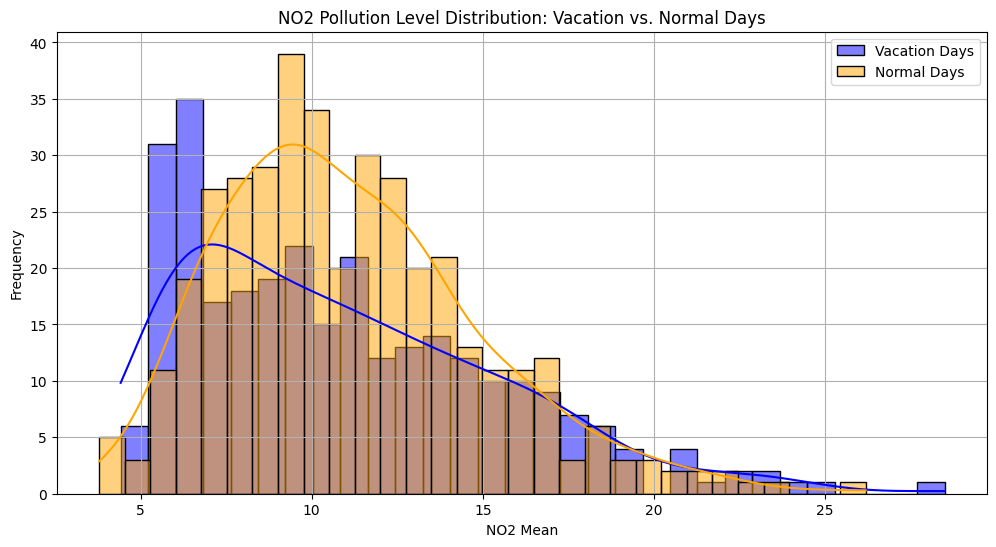

In [20]:
import seaborn as sns

# Plot distribution of NO2 Mean on Vacation vs. Normal Days
plt.figure(figsize=(12, 6))
sns.histplot(df[df['Is_Vacation']]['NO2 Mean'], bins=30, color='blue', label='Vacation Days', kde=True)
sns.histplot(df[~df['Is_Vacation']]['NO2 Mean'], bins=30, color='orange', label='Normal Days', kde=True)
plt.xlabel("NO2 Mean")
plt.ylabel("Frequency")
plt.title("NO2 Pollution Level Distribution: Vacation vs. Normal Days")
plt.legend()
plt.grid(True)
plt.show()

21.Compare Pollution Trends Over Time

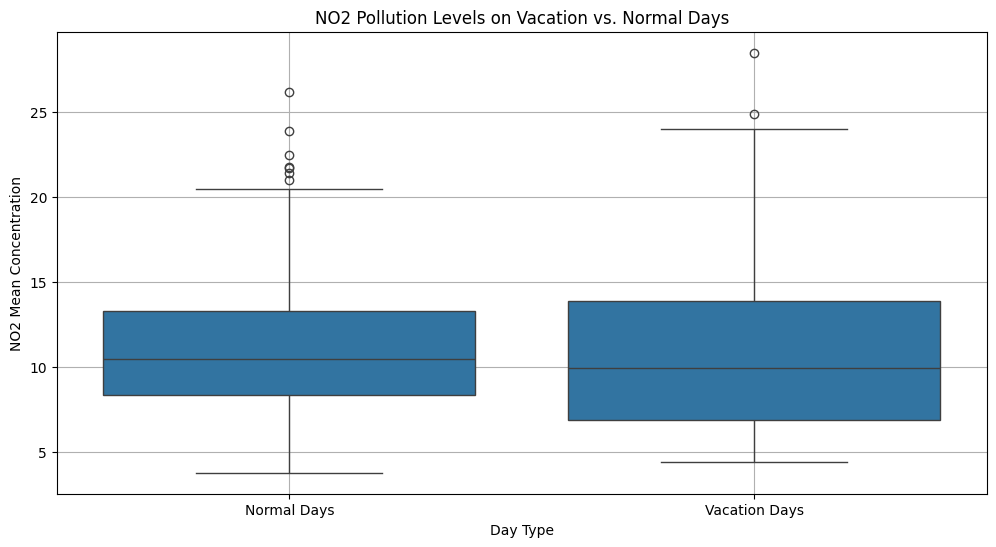

In [21]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df['Is_Vacation'], y=df['NO2 Mean'])
plt.xticks(ticks=[0, 1], labels=['Normal Days', 'Vacation Days'])
plt.title("NO2 Pollution Levels on Vacation vs. Normal Days")
plt.xlabel("Day Type")
plt.ylabel("NO2 Mean Concentration")
plt.grid(True)
plt.show()

22.Perform Statistical Tests

In [22]:
from scipy.stats import ttest_ind

vacation_pollution = df[df['Is_Vacation']]['NO2 Mean']
normal_pollution = df[~df['Is_Vacation']]['NO2 Mean']

# Perform a T-test
t_stat, p_value = ttest_ind(vacation_pollution, normal_pollution, equal_var=False)

print(f"T-Test Statistic: {t_stat}")
print(f"P-Value: {p_value}")

# Interpretation
if p_value < 0.05:
    print("Significant difference in pollution levels between vacation and normal days.")
else:
    print("No significant difference in pollution levels between vacation and normal days.")

T-Test Statistic: -0.6711268308579802
P-Value: 0.5024168088475511
No significant difference in pollution levels between vacation and normal days.
